In [21]:
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
import csv
from IPython.display import display

# =========================== 1. 定义反应物 ===========================

amines = [
    ('CCN(CC)CCNC', 'amines_head_1')
    # 可继续添加 ('SMILES', '描述')
]

aldehydes = [
    ('CCCCCCCCC(CC)OC(=O)C1=CC=C(C=O)C=C1', 'aldehydes_linker_1'),
    ('CCCCCCCCCCCOC(=O)C1=CC=C(C=O)C=C1','aldehydes_linker_2')
    # 可继续添加
]

alkynes = [
    ('C#CCCCC(=O)OC(CCCCCCCC)CCCCCCCC', 'alkynes_tail_1'),
    ('C#CCCCC(=O)OC(C)CCCCCCCCCC','alkynes_tail_2')
    # 可继续添加
]



In [22]:
def process_and_save_products(product_mols, step_name):
    """
    1) 去重 & 转SMILES
    2) 打印SMILES到控制台
    3) 输出到 CSV: f"{step_name}_products.csv"
    4) 在 Notebook 中显示网格图, 并保存到 f"{step_name}_products.png"
    5) 返回去重 & sanitize 后的有效 Mols
    """
    import csv
    from rdkit import Chem
    from rdkit.Chem import Draw
    from IPython.display import display

    if not product_mols:
        print(f"[{step_name}] 没有产物生成.")
        return []

    # 1) 去重并转成 SMILES
    unique_smiles = list(set(Chem.MolToSmiles(m, isomericSmiles=True) for m in product_mols))
    print(f"[{step_name}] 原产物数: {len(product_mols)}, 去重后: {len(unique_smiles)}")

    # 2) 在控制台打印 SMILES
    print(f"[{step_name}] 产物 SMILES 列表 (去重后):")
    for smi in unique_smiles:
        print("  ", smi)

    # 3) 转回 Mol，并进行 Sanitize 检查
    valid_mols = []
    invalid_smiles = []
    for smi in unique_smiles:
        mol = Chem.MolFromSmiles(smi)
        if mol is None:
            print(f"[警告] 无法从 SMILES 解析: {smi}")
            invalid_smiles.append(smi)
            continue
        try:
            Chem.SanitizeMol(mol)  # RDKit 化学有效性检查
            valid_mols.append(mol)  # 通过的分子
        except Exception as e:
            print(f"[非法产物] SMILES: {smi} | 错误: {e}")
            invalid_smiles.append(smi)

    print(f"[{step_name}] Sanitize 检查后有效产物数: {len(valid_mols)}，非法产物数: {len(invalid_smiles)}")

    # 4) 保存有效产物 CSV
    csv_filename = f"{step_name}_products.csv"
    with open(csv_filename, "w", newline="", encoding="utf-8") as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["编号", "SMILES"])
        for idx, mol in enumerate(valid_mols, start=1):
            smi = Chem.MolToSmiles(mol, isomericSmiles=True)
            writer.writerow([idx, smi])
    print(f"[{step_name}] 有效产物 CSV 已保存: {csv_filename}")

    # 5) 保存非法产物 CSV（如果有）
    if invalid_smiles:
        invalid_csv_filename = f"{step_name}_invalid_products.csv"
        with open(invalid_csv_filename, "w", newline="", encoding="utf-8") as csvfile:
            writer = csv.writer(csvfile)
            writer.writerow(["SMILES"])
            for smi in invalid_smiles:
                writer.writerow([smi])
        print(f"[{step_name}] 非法产物 CSV 已保存: {invalid_csv_filename}")

    # 6) Notebook 中显示网格图
    if valid_mols:
        img_for_notebook = Draw.MolsToGridImage(valid_mols, molsPerRow=4, subImgSize=(200, 200))
        display(img_for_notebook)

        # 7) 可选: 保存 PNG (注释可取消启用)
        # png_filename = f"{step_name}_products.png"
        # img_data = Draw.MolsToGridImage(valid_mols, molsPerRow=4, subImgSize=(200, 200), returnPNG=True)
        # with open(png_filename, "wb") as f:
        #     f.write(img_data)
        # print(f"[{step_name}] 图片已保存: {png_filename}")

    return valid_mols  # 返回最终有效分子


反应有效性: False

总产物数: 4
[A3_Coupling] 原产物数: 4, 去重后: 4
[A3_Coupling] 产物 SMILES 列表 (去重后):
   CCCCCCCCCCC(C)OC(=O)CCCC#CC(c1ccc(C(=O)OC(CC)CCCCCCCC)cc1)N(C)CCN(CC)CC
   CCCCCCCCC(CCCCCCCC)OC(=O)CCCC#CC(c1ccc(C(=O)OC(CC)CCCCCCCC)cc1)N(C)CCN(CC)CC
   CCCCCCCCCCCOC(=O)c1ccc(C(C#CCCCC(=O)OC(C)CCCCCCCCCC)N(C)CCN(CC)CC)cc1
   CCCCCCCCCCCOC(=O)c1ccc(C(C#CCCCC(=O)OC(CCCCCCCC)CCCCCCCC)N(C)CCN(CC)CC)cc1
[A3_Coupling] Sanitize 检查后有效产物数: 4，非法产物数: 0
[A3_Coupling] 有效产物 CSV 已保存: A3_Coupling_products.csv


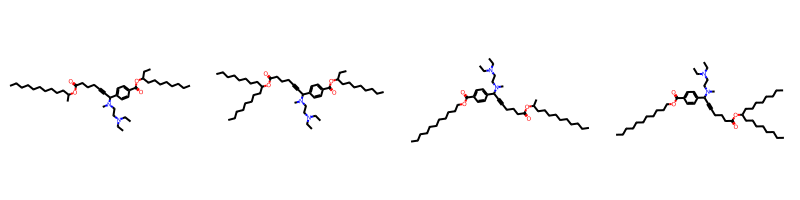

In [23]:
# =========================== 2. 定义反应 SMARTS ===========================

#reaction_smarts = "[NH:1].[CX3H:2]=O[#6].[C:3]#[CH:4]>>[CH:3]#[C:4][C:2][N:1]"
reaction_smarts = "[NH:1].[CX3H:2]=O.[CH:3]#[C:4]>>[N:1][C:2][C:3]#[C:4]"
reaction = AllChem.ReactionFromSmarts(reaction_smarts)
print("反应有效性:", reaction.IsInitialized())  # 检查反应是否被正确识别

# =========================== 3. 存储产物集合 ===========================

product_mols = []

# =========================== 4. 遍历反应 ===========================

for amine_smiles, amine_desc in amines:
    for aldehyde_smiles, aldehyde_desc in aldehydes:
        for alkyne_smiles, alkyne_desc in alkynes:
            # 转Mol对象
            amine = Chem.MolFromSmiles(amine_smiles)
            aldehyde = Chem.MolFromSmiles(aldehyde_smiles)
            alkyne = Chem.MolFromSmiles(alkyne_smiles)

            if None in (amine, aldehyde, alkyne):
                print(f"[警告] 无效反应物: {amine_desc}, {aldehyde_desc}, {alkyne_desc}")
                continue

            # 执行反应
            products = reaction.RunReactants([amine, aldehyde, alkyne])

            for product_set in products:
                for product in product_set:
                    try:
                        Chem.SanitizeMol(product)  # 标准化检查
                        product_mols.append(product)  # 收集产物
                    except Chem.AtomValenceException as e:
                        print(f"[非法产物] 跳过: {Chem.MolToSmiles(product)} | 错误: {e}")

print(f"\n总产物数: {len(product_mols)}")


# 调用处理函数
final_unique_products = process_and_save_products(product_mols, "A3_Coupling")



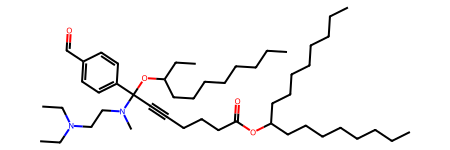

In [6]:
mol13 = Chem.MolFromSmiles("CCCCCCCCC(CCCCCCCC)OC(=O)CCCC#CC(OC(CC)CCCCCCCC)(c1ccc(C=O)cc1)N(C)CCN(CC)CC")
mol13

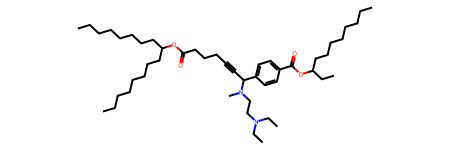

In [7]:
mol13 = Chem.MolFromSmiles("CCCCCCCCC(CCCCCCCC)OC(=O)CCCC#CC(c1ccc(C(=O)OC(CC)CCCCCCCC)cc1)N(C)CCN(CC)CC")
mol13

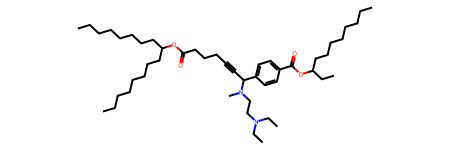

In [15]:
mol13 = Chem.MolFromSmiles("CCCCCCCCC(CCCCCCCC)OC(=O)CCCC#CC(c1ccc(C(=O)OC(CC)CCCCCCCC)cc1)N(C)CCN(CC)CC")
mol13

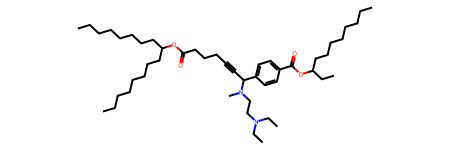

In [17]:
mol13 = Chem.MolFromSmiles("CCCCCCCCC(CCCCCCCC)OC(=O)CCCC#CC(C1=CC=C(C(=O)OC(CC)CCCCCCCC)C=C1)N(C)CCN(CC)CC")
mol13